Variational Autoencoder test

Python version: x <br>
PyTorch version: y <br>
Numpy version: z <br>

In [79]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
print(torch.__version__)
print(np.__version__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")

print(DEVICE)

image_size = (16, 16)
image_vector_dim = image_size[0] * image_size[1]

object_size = (4, 4)

input_dimension = image_size[0] * image_size[1]
hidden_dimension_encoder = 60
latent_dimension = 2
hidden_dimension_decoder = 60

output_dimension = image_size[0] * image_size[1]

dataset_size = 5000
batch_size = 10
epochs = 40
learning_rate = 0.001

2.5.0+cu118
2.1.0
cuda


In [80]:
from typing import Tuple
import matplotlib.pyplot as plt

class RandomImageDataset(Dataset):
    def __init__(self, dataset_size, image_size, object_size):
        self.dataset_size = dataset_size
        self.image_size = image_size
        self.object_size = object_size

    def __len__(self) -> int:
        return self.dataset_size

    def __getitem__(self, idx: int):
        z = torch.zeros(self.image_size)
        o = torch.ones(self.object_size)

        object_x_min = 0
        object_x_max = self.image_size[0] - self.object_size[0]

        object_y_min = 0
        object_y_max = self.image_size[0] - self.object_size[0]

        object_x = np.random.randint(object_x_min, object_x_max)
        object_y = np.random.randint(object_y_min, object_y_max)

        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = o        
        return z


#dataset_test = RandomImageDataset(image_size = image_size)
#plt.imshow(dataset_test.__getitem__(123), cmap='gray')
#plt.axis('off')
#plt.title('Test image')
#plt.show()

dataset_training = RandomImageDataset(dataset_size=dataset_size, image_size=image_size, object_size=object_size)
dataset_testing = RandomImageDataset(dataset_size=dataset_size, image_size=image_size, object_size=object_size)

dataloader_training = DataLoader(dataset_training, batch_size=batch_size)
dataloader_testing = DataLoader(dataset_testing, batch_size=batch_size)

In [81]:
# Encoder
class StandardEncoder(torch.nn.Module):
    def __init__(self, input_dimension: int, hidden_dimension: int, latent_dimension: int):
        super(StandardEncoder, self).__init__()
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.latent_dimension = latent_dimension

        self.fc0 = torch.nn.Linear(input_dimension, hidden_dimension)
        self.mean = torch.nn.Linear(hidden_dimension, latent_dimension)
        self.lat = torch.nn.Linear(hidden_dimension, latent_dimension)

        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        #mean = self.mean(t)
        lat = self.lat(t)

        return lat
        #return mean, var



class VariationalEncoder(StandardEncoder):
    def __init__(self, input_dimension: int, hidden_dimension: int, latent_dimension: int):
        super(VariationalEncoder, self).__init__(input_dimension=input_dimension, hidden_dimension=hidden_dimension, latent_dimension=latent_dimension)
        #self.input_dimension = input_dimension
        #self.hidden_dimension = hidden_dimension
        #self.latent_dimension = latent_dimension

        #self.fc0 = torch.nn.Linear(input_dimension, hidden_dimension)
        #self.mean = torch.nn.Linear(hidden_dimension, latent_dimension)
        self.var = torch.nn.Linear(hidden_dimension, latent_dimension)

        #self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        mean = self.lat(t)
        var = self.var(t)

        return mean, var


In [82]:
# Decoder

class Decoder(torch.nn.Module):
    def __init__(self, latent_dimension, hidden_dimension, output_dimension):
        super(Decoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension

        self.fc0 = torch.nn.Linear(latent_dimension, hidden_dimension)
       
        #self.fc1 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        self.output = torch.nn.Linear(hidden_dimension, output_dimension)

        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        
        t = torch.sigmoid(self.output(t))

        return t
    

In [83]:
# Model

class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_dimension = input_dimension, hidden_dimension = hidden_dimension_encoder, latent_dimension = latent_dimension)
        self.decoder = Decoder(latent_dimension = latent_dimension, hidden_dimension = hidden_dimension_decoder, output_dimension = output_dimension)

        
    def forward(self, data):
        mean, var = self.encoder(data)
        e = torch.randn_like(var).to(DEVICE)
        z = mean + torch.exp(0.5* var) * e

        data_ = self.decoder(z)

        return data_, mean, var


class StandardAutoencoder(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension):
        super(StandardAutoencoder, self).__init__()
        self.encoder = StandardEncoder(input_dimension = input_dimension, hidden_dimension = hidden_dimension_encoder, latent_dimension = latent_dimension)
        self.decoder = Decoder(latent_dimension = latent_dimension, hidden_dimension = hidden_dimension_decoder, output_dimension = output_dimension)

    def forward(self, data):
        lat = self.encoder(data)
        data_ = self.decoder(lat)

        return data_
        

vae = VariationalAutoencoder(input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension)
sae = StandardAutoencoder(input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension)
vae.to(DEVICE)
sae.to(DEVICE)

# loss

from torch.optim import Adam

def vae_loss(data, data_, mean, var):
    loss = torch.nn.functional.binary_cross_entropy(data_, data, reduction='sum')
    KLD = -0.5 * torch.sum(1+ var - mean.pow(2) - var.exp())
    return loss + KLD

def sae_loss(data, data_):
    loss = torch.nn.functional.binary_cross_entropy(data_, data, reduction='sum')
    return loss

optimizer_vae = Adam(vae.parameters(), lr = learning_rate)
optimizer_sae = Adam(sae.parameters(), lr = learning_rate)


vae.train()
#sae.train()

for e in range(epochs):
    epoch_loss_vae = 0
    epoch_loss_sae = 0
    for data in dataloader_training:
        data = data.view(batch_size, image_vector_dim)
        data = data.to(DEVICE)

        optimizer_vae.zero_grad()
        optimizer_sae.zero_grad()

        data_vae, mean, var = vae(data)
        data_sae            = sae(data)
        
        loss_vae = vae_loss(data, data_vae, mean, var)
        loss_sae = sae_loss(data, data_sae)
        
        epoch_loss_vae += loss_vae.item()
        epoch_loss_sae += loss_sae.item()
        
        loss_vae.backward()
        loss_sae.backward()
        optimizer_vae.step()
        optimizer_sae.step()
    print("epoch",e," loss_vae:", epoch_loss_vae, " loss_sae:", epoch_loss_sae)

epoch 0  loss_vae: 313974.11068725586  loss_sae: 280141.05001831055
epoch 1  loss_vae: 211524.54586791992  loss_sae: 169319.86613464355
epoch 2  loss_vae: 175709.82571411133  loss_sae: 135530.85961914062
epoch 3  loss_vae: 158784.5479736328  loss_sae: 117732.59031677246
epoch 4  loss_vae: 146310.6693572998  loss_sae: 106070.09313964844
epoch 5  loss_vae: 136414.10833740234  loss_sae: 96689.9190826416
epoch 6  loss_vae: 130000.765625  loss_sae: 88264.2223815918
epoch 7  loss_vae: 123057.3805847168  loss_sae: 83232.2250289917
epoch 8  loss_vae: 118553.1887512207  loss_sae: 78513.86515045166
epoch 9  loss_vae: 113912.99775695801  loss_sae: 73288.1217880249
epoch 10  loss_vae: 110539.7431640625  loss_sae: 71042.45865631104
epoch 11  loss_vae: 106952.09423828125  loss_sae: 67844.04853057861
epoch 12  loss_vae: 105172.75991821289  loss_sae: 65784.49081420898
epoch 13  loss_vae: 100967.13430786133  loss_sae: 64238.42505645752
epoch 14  loss_vae: 99492.28720092773  loss_sae: 61237.87761306763


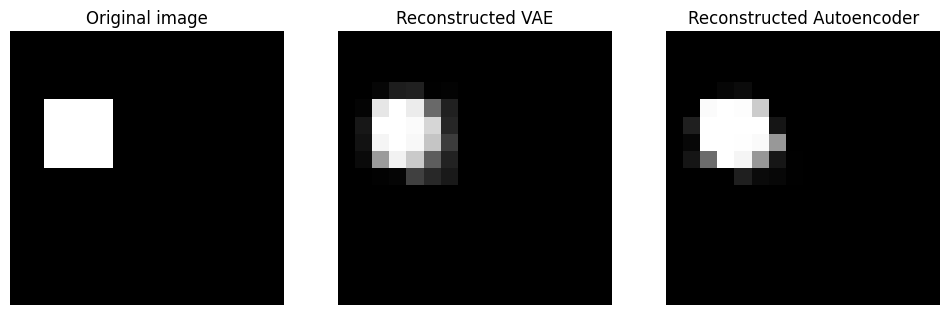

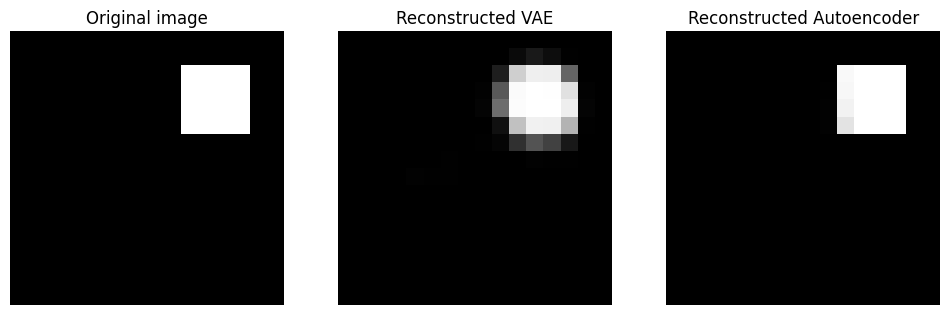

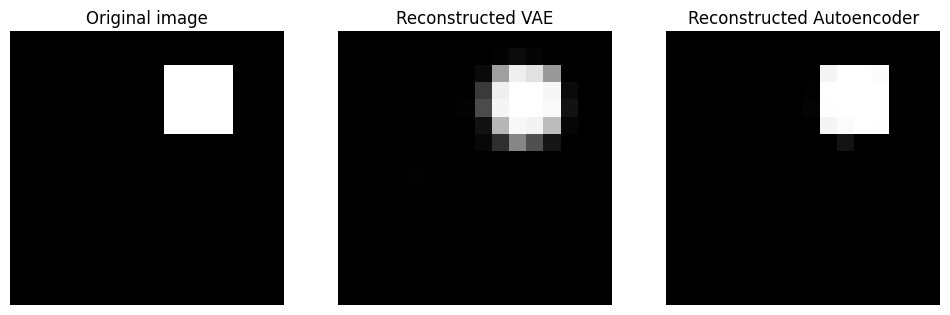

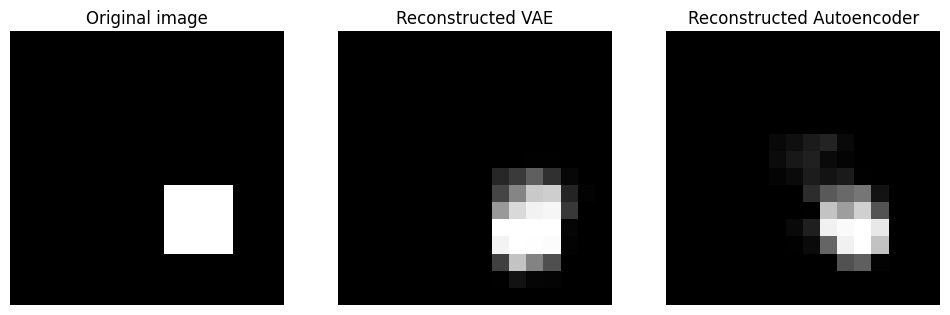

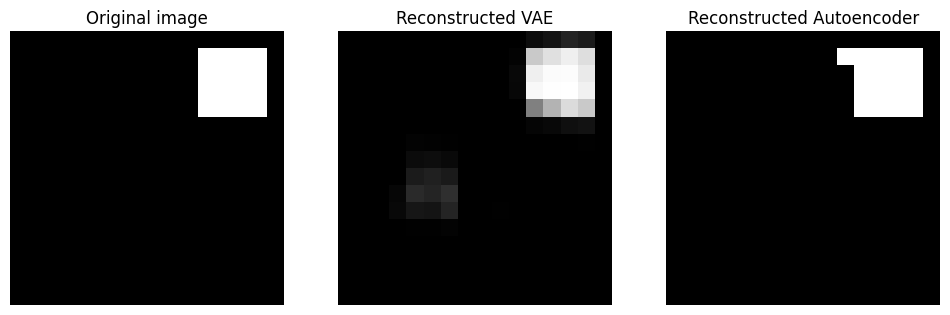

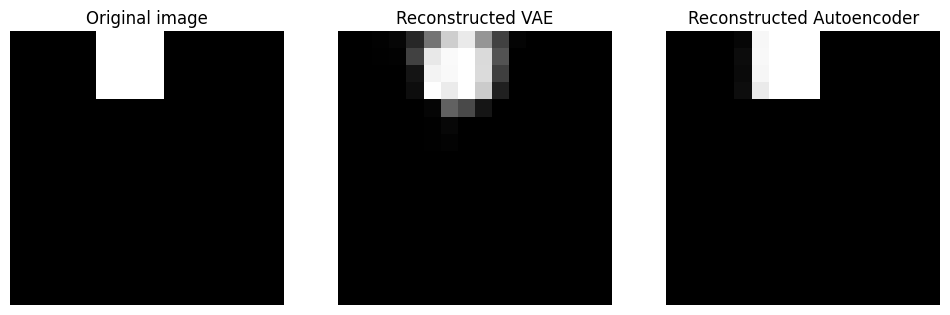

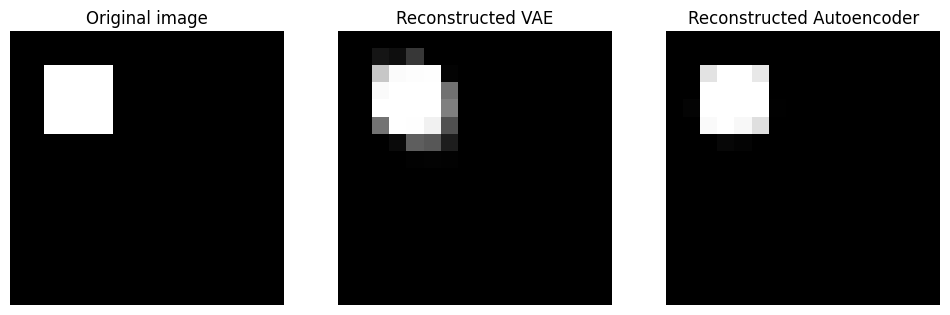

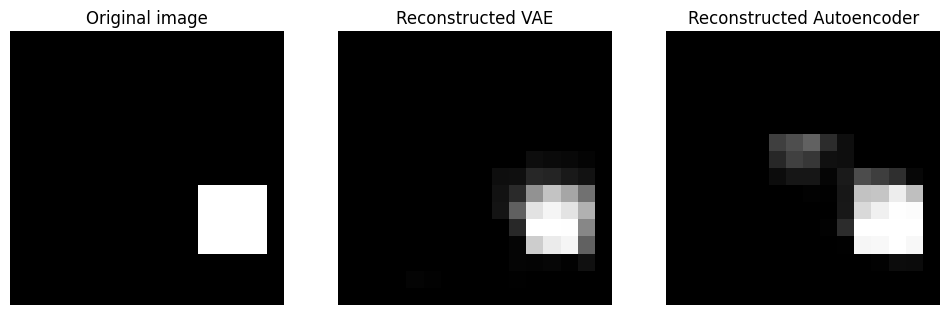

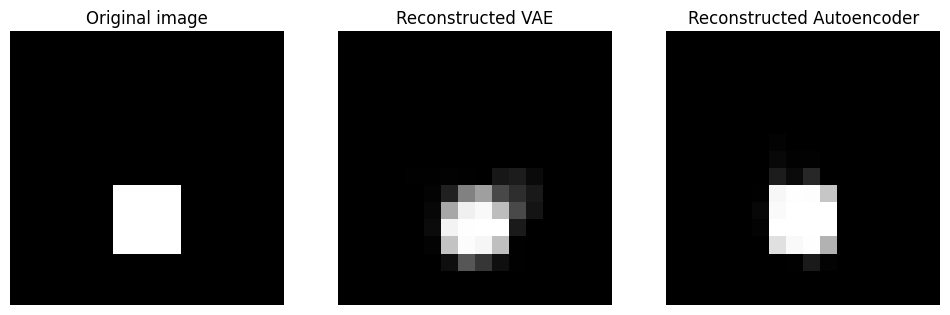

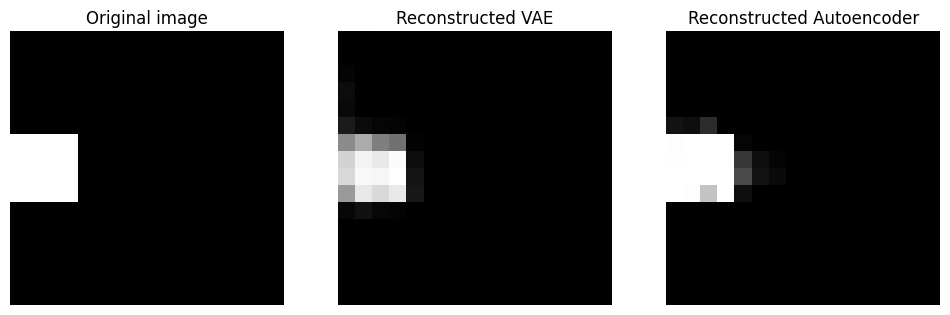

torch.Size([10, 16, 16])


In [84]:
# Visualize

vae.eval()

for data in dataloader_testing:
    data = data.view(batch_size, image_vector_dim)
    
    data=data.to(DEVICE)

    data_vae, mean, variance = vae(data)
    data_sae                 = sae(data)
    
    
    data = data.view(batch_size, image_size[0], image_size[1])
    data_vae = data_vae.view(batch_size, image_size[0], image_size[1])
    data_sae = data_sae.view(batch_size, image_size[0], image_size[1])

    
    for i in range(batch_size):
        im0 = data[i]
        im0_np = im0.cpu().detach().numpy()
        im1 = data_vae[i]
        im1_np = im1.cpu().detach().numpy()
        im2 = data_sae[i]
        im2_np = im2.cpu().detach().numpy()
        
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.imshow(im0_np, cmap='gray')
        plt.axis('off')
        plt.title('Original image')
        plt.subplot(1,3,2)
        plt.imshow(im1_np, cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed VAE')
        plt.subplot(1,3,3)
        plt.imshow(im2_np, cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed Autoencoder')
        
        plt.show()
    print(data_.shape)
    break

